# Model evaluation

This dataframe explores the recorded data from a model.

In [1]:
# set working directoy to root directory of the project
if not "working_directory_corrected" in vars():
    %cd ..
    %cd ..
    %cd ..
    working_directory_corrected = True
    
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

c:\Users\frank\Documents\Research\projects\evohome\environment\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


c:\Users\frank\Documents\Research\projects\evohome\examples\simple_scenario
c:\Users\frank\Documents\Research\projects\evohome\examples
c:\Users\frank\Documents\Research\projects\evohome


## Data Loading

Below we load the data. This dataset contains the following values:
- weekday: the day of the week
- hour: the hour of the day
- minute: the minute of the hour
- room_x: the actual value of room x
- prediction_x: the predicted value of room x

Additional data processing:
- For look-ahead scenarios the first few predicted values are typically NaN values. We drop them from the dataset.
- We convert predictions to type integer (booleans are represented as 0 = false, 1 = true)
- We convert date into datetime type and set it to be the index of the data frame

In [2]:
data_frame = pd.read_pickle("examples/simple_scenario/data/running.pickle")
nr_rooms = (len(data_frame.columns) - 3) // 2
data_frame.dropna(axis = 0, how = "any", inplace = True)

for index in range(nr_rooms):
    column = "prediction_" + str(index)
    data_frame[column] = data_frame[column].astype('int32')

data_frame["date"] = pd.to_datetime(data_frame["date"])
data_frame.set_index(pd.DatetimeIndex(data_frame["date"]), inplace=True)
data_frame.drop("date", axis = 1, inplace= True)

print(f"The dataframe has {len(data_frame)} samples.")
print(f"The example scenario has {nr_rooms} rooms.")
print("below are five random samples")
data_frame


The dataframe has 1036740 samples.
The example scenario has 11 rooms.
below are five random samples


,room_0,prediction_0,room_1,prediction_1,room_2,prediction_2,room_3,prediction_3,room_4,prediction_4,...,prediction_7,room_8,prediction_8,room_9,prediction_9,room_10,prediction_10,weekday,hour,minute
date,,,,,,,,,,,,,,,,,,,,,
2020-06-06 01:01:00,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,5,1,1
2020-06-06 01:02:00,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,5,1,2
2020-06-06 01:03:00,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,5,1,3
2020-06-06 01:04:00,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,5,1,4
2020-06-06 01:05:00,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,5,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26 23:56:00,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,3,23,56
2022-05-26 23:57:00,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,3,23,57
2022-05-26 23:58:00,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,3,23,58


## Score Development

Below we split the dataset into days and calculate per room and average scores for each day.
As score we use the F1 score, where the positive class is presence in a room.

In [3]:
def get_f1(data_frame):
    f1s = []
    for index in range(nr_rooms):
        f1s.append(metrics.f1_score(y_pred = data_frame["prediction_" + str(index)], 
                                                 y_true = data_frame["room_" + str(index)],
                                                 zero_division = 1))
    return f1s

by_day_data = data_frame.groupby(data_frame.index.date)
days = [group[0] for group in by_day_data]
day_scores = [get_f1(group[1]) for group in by_day_data]
day_scores = pd.DataFrame(day_scores, index=pd.DatetimeIndex(days))

day_scores["average"] = day_scores[0]
for index in range(1,nr_rooms):
    day_scores["average"] += day_scores[index]
day_scores["average"] /= nr_rooms


We now visualize the average accuracy per day.
The visualized time frame can be adjusted by changint start and end date. 
Minimum and maximum date can be read from the above dataframe visualization

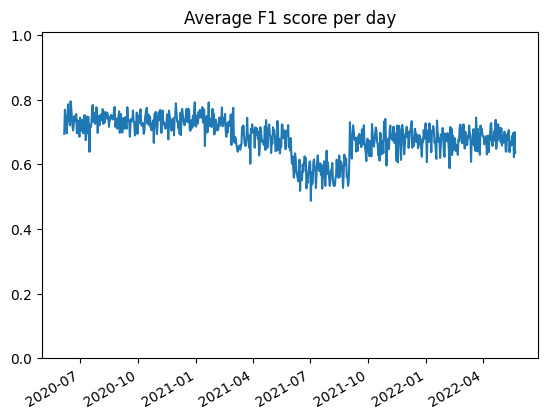

In [4]:

start_date = datetime(year = 2020,month=6, day = 1)
end_date = datetime(year = 2022,month=5, day = 22)

fig, ax = plt.subplots()
ax.plot(day_scores[start_date:end_date]["average"])
ax.set_title("Average F1 score per day")
ax.set_ylim([0.0, 1.01])
fig.autofmt_xdate()
plt.show()

Next we visulize the accuracy per room.

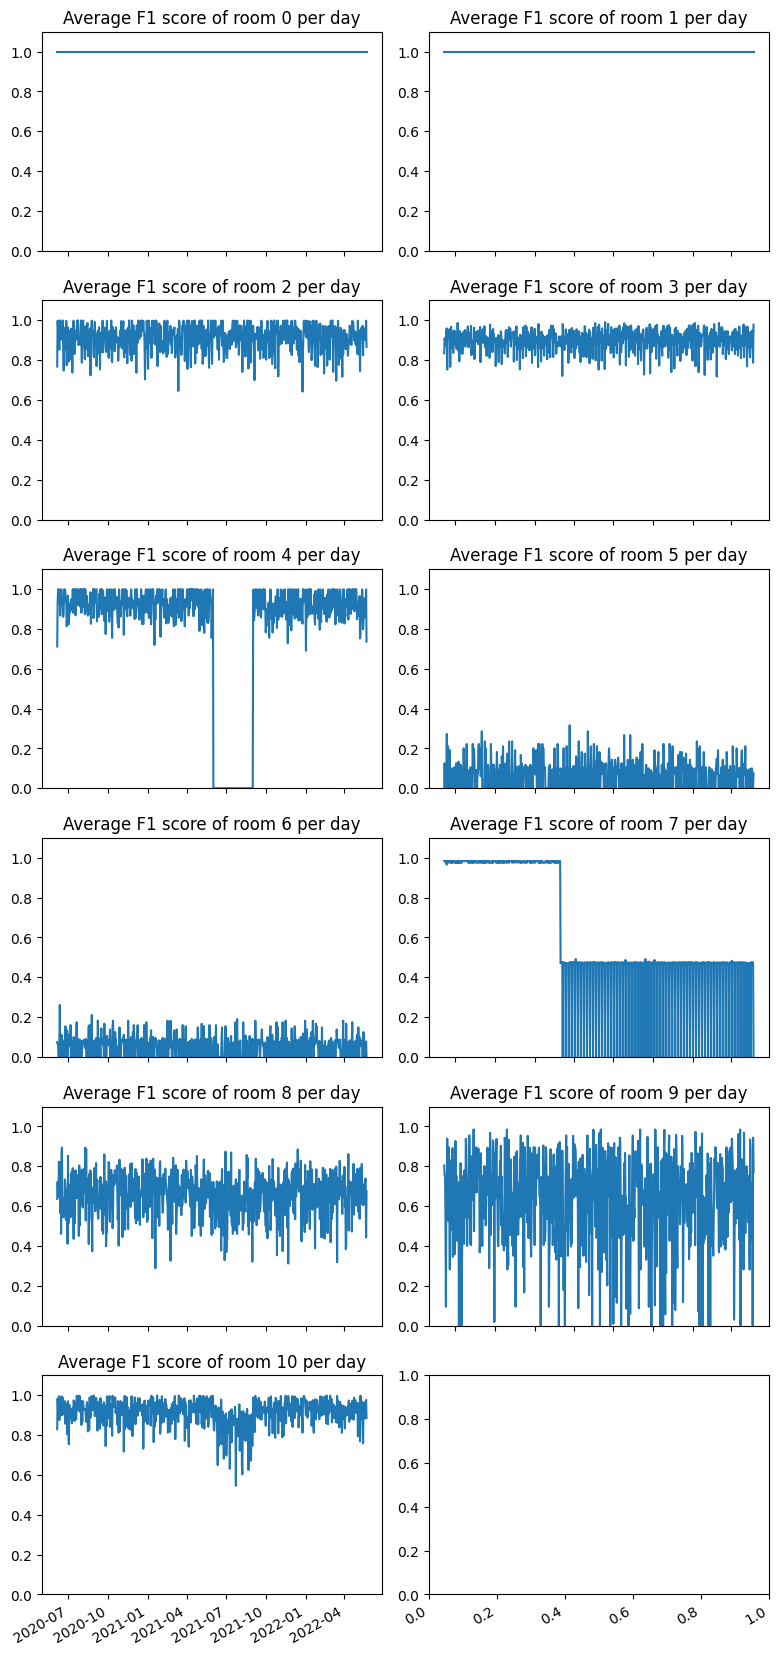

In [5]:
start_date = datetime(year = 2020,month=6, day = 1)
end_date = datetime(year = 2022,month=5, day = 22)

nr_cols = 2

fig, subplots = plt.subplots(ncols= nr_cols,nrows= (nr_rooms+1) //nr_cols, figsize = (8,20))

for room_index in range(nr_rooms):
    ax = subplots[room_index//nr_cols][room_index% nr_cols]
    ax.set_title(f"Average F1 score of room {room_index} per day")
    ax.plot(day_scores[start_date:end_date][room_index])
    ax.set_ylim([0, 1.1])
    
fig.tight_layout()
fig.autofmt_xdate()
plt.show()